# Training a RESNET on CIFAR using Pytorch Lightning

In [1]:
!pip install --quiet pytorch-lightning lightning-bolts gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.1/731.1 kB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.2/294.2 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.3 MB/s eta

In [2]:
%%writefile resnet.py


import torch.nn.functional as F
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(
                          in_channels=in_channels, out_channels=out_channels, \
                          kernel_size=3, stride=stride,\
                          padding=1, bias=False
                          )
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(
                          in_channels=out_channels, out_channels=out_channels, \
                          kernel_size=3, stride=1,\
                          padding=1, bias=False
                          )
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = x+nn.Sequential()(x)
        return x

class LayerBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LayerBlock, self).__init__()
        self.inner_layer = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=out_channels,\
            kernel_size=3,stride=1,\
            padding=1,bias=False,
            ),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )
        self.res_block = ResidualBlock(out_channels, out_channels)

    def forward(self, x):
        x = self.inner_layer(x)
        r = self.res_block(x)
        out = x + r
        return out

class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()

        self.prep_layer = nn.Sequential(
                              nn.Conv2d(in_channels=3,out_channels=64,\
                                        kernel_size=3,stride=1,\
                                        padding=1,bias=False,\
                              ),
                              nn.BatchNorm2d(64),\
                              nn.ReLU(),
                          )

        self.layer_1 = LayerBlock(in_channels=64, out_channels=128)
        self.layer_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128,out_channels=256,kernel_size=3,
                stride=1,padding=1,bias=False,
            ),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.layer_3 = LayerBlock(in_channels=256, out_channels=512)
        self.max_pool = nn.Sequential(nn.MaxPool2d(kernel_size=4))
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        x = self.prep_layer(x)
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.max_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Writing resnet.py


In [3]:
import os

import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from IPython.core.display import display
from pl_bolts.datamodules import CIFAR10DataModule
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.swa_utils import AveragedModel, update_bn
from torchmetrics.functional import accuracy

seed_everything(7)

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
BATCH_SIZE = 256 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2)

/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapCon

In [4]:
from resnet import ResNet

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:

train_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

test_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        cifar10_normalization(),
    ]
)

cifar10_dm = CIFAR10DataModule(
    data_dir=PATH_DATASETS,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    val_transforms=test_transforms,
)

In [6]:
def create_model():
    return ResNet()

In [7]:
class LitResnet(LightningModule):
    def __init__(self, lr=0.05):
        super().__init__()

        self.save_hyperparameters()
        self.model = create_model()

    def forward(self, x):
        out = self.model(x)
        return F.log_softmax(out, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task='multiclass',num_classes=10)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams.lr,
            momentum=0.9,
            weight_decay=5e-4,
        )
        steps_per_epoch = 45000 // BATCH_SIZE
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                0.1,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=steps_per_epoch,
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

In [8]:
model = LitResnet(lr=0.05)

trainer = Trainer(
    max_epochs=30,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=10)],
)

trainer.fit(model, cifar10_dm)
trainer.test(model, datamodule=cifar10_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


100%|██████████| 170498071/170498071 [00:01<00:00, 90394716.93it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 6.6 M 
---------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.293    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9129999876022339
        test_loss           0.3034403920173645
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.3034403920173645, 'test_acc': 0.9129999876022339}]

,lr-SGD,train_loss,val_loss,val_acc,test_loss,test_acc
epoch,,,,,,
NaN,0.004229,NaN,NaN,NaN,NaN,NaN
0.0,NaN,3.409287,NaN,NaN,NaN,NaN
NaN,0.004934,NaN,NaN,NaN,NaN,NaN
0.0,NaN,2.386371,NaN,NaN,NaN,NaN
NaN,0.006107,NaN,NaN,NaN,NaN,NaN


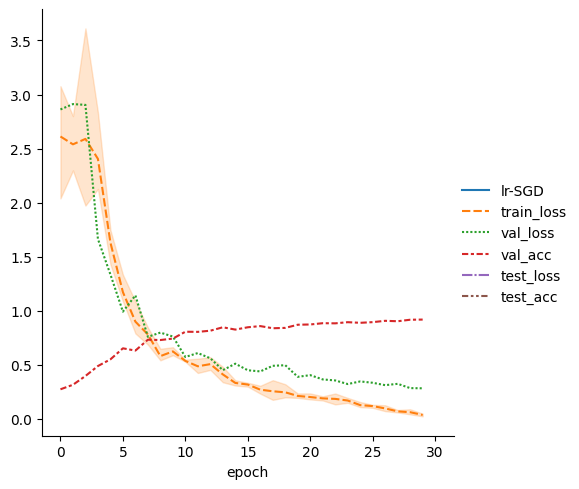

In [9]:

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

In [10]:
torch.save(model.state_dict(), './model.pth')